In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Activation, Dropout, Dense, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageOps

In [2]:
# comment this cell if nparray is already saved

def load_images_from_folder(folder, label, desired_size=128):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            # Calculate padding
            pixels = np.array(img)
            min_pixel, max_pixel = pixels.min(), pixels.max()
            padding = int((max_pixel - min_pixel) / 10)  # Example padding calculation

            # Add padding to the image
            img = ImageOps.expand(img, border=padding, fill='black')
            
            # convert to rgb
            img = img.convert('RGB')

            # Resize to the desired size
            img = img.resize((desired_size, desired_size))

            images.append(np.array(img)) 
            labels.append(label)
    return images, labels

# Load images from two directories
class0_images, class0_labels = load_images_from_folder('Data/public/non_globally_sclerotic_glomeruli', 0 )
class1_images, class1_labels = load_images_from_folder('Data/public/globally_sclerotic_glomeruli', 1)

# save labels and images in numpy arrays
np.save('Data_created/class0_images.npy', class0_images)
np.save('Data_created/class0_labels.npy', class0_labels)
np.save('Data_created/class1_images.npy', class1_images)
np.save('Data_created/class1_labels.npy', class1_labels)


In [3]:
#load images from numpy arrays
class0_images = np.load('Data_created/class0_images.npy')
class0_labels = np.load('Data_created/class0_labels.npy')
class1_images = np.load('Data_created/class1_images.npy')
class1_labels = np.load('Data_created/class1_labels.npy')


import matplotlib.pyplot as plt

# Display images from class0_images
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(class0_images[i])
    plt.axis('off')
    plt.title('Class 0')
    
# Display images from class1_images
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(class1_images[i+5])
    plt.axis('off')
    plt.title('Class 1')

plt.tight_layout()
plt.show()

In [4]:
# concatenate the images and labels
images = np.concatenate([class0_images, class1_images])
labels = np.concatenate([class0_labels, class1_labels])

In [5]:
# Create a data generator for data augmentation
# augmentation class 1

class1_augemtation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

num_imgages_to_generate = len(class0_images) - len(class1_images)

class1_augmented_images = []
class1_augmented_labels = []
for i in range(num_imgages_to_generate):
    img = class1_images[i % len(class1_images)]
    img = class1_augemtation(np.expand_dims(img, 0))
    class1_augmented_images.append(img[0])
    class1_augmented_labels.append(1)

In [6]:
# concat the augmented images and labels to the original images and labels
images = np.concatenate([images, class1_augmented_images])
labels = np.concatenate([labels, class1_augmented_labels])

#save the augmented images and labels
np.save('Data_created/images.npy', images)
np.save('Data_created/labels.npy', labels)

In [7]:

# Load the images and labels
images = np.load('Data_created/images.npy')
labels = np.load('Data_created/labels.npy')

raw_images = np.load('Data_created/raw_images.npy')
raw_labels = np.load('Data_created/raw_labels.npy')

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape = (128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

added_new_model = base_model.output
added_new_model = Flatten(name="flatten")(added_new_model)
added_new_model = Dense(4096, activation='relu')(added_new_model)
added_new_model = Dense(1072, activation='relu')(added_new_model)
added_new_model = Dropout(0.2)(added_new_model)
output_layer = Dense(1, activation='sigmoid')(added_new_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with your loaded data using the data loader
model_history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9122 - loss: 2.7882 - val_accuracy: 0.9782 - val_loss: 0.0597
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9833 - loss: 0.0476 - val_accuracy: 0.9830 - val_loss: 0.0550
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9834 - loss: 0.0538 - val_accuracy: 0.9750 - val_loss: 0.0796
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9907 - loss: 0.0312 - val_accuracy: 0.9761 - val_loss: 0.0819
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9933 - loss: 0.0192 - val_accuracy: 0.9841 - val_loss: 0.0576
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9954 - loss: 0.0131 - val_accuracy: 0.9851 - val_loss: 0.0802
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9948 - loss: 0.0143 - val_accuracy: 0.9851 - val_loss: 0.1002
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9972 - loss: 0.0099 - val_accu

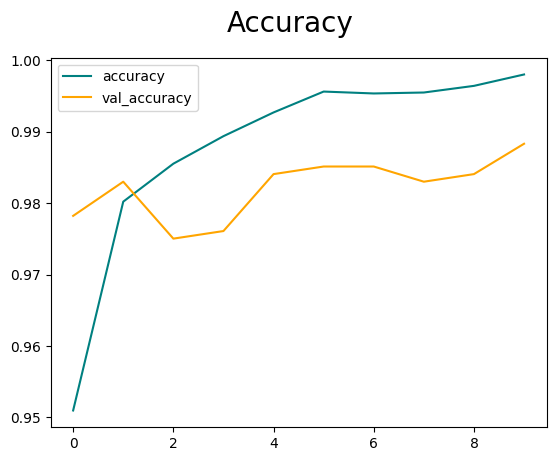

In [11]:
fig = plt.figure()
plt.plot(model_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

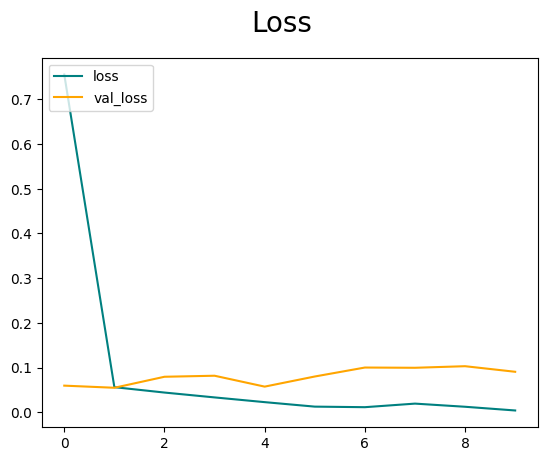

In [12]:
fig = plt.figure()
plt.plot(model_history.history['loss'], color='teal', label='loss')
plt.plot(model_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
## save the model
model.save('resnet50model.h5')

In [14]:
#evaluate the model
model.evaluate(x_val, y_val)

#create confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_val)
y_pred = np.round(y_pred)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.9914 - loss: 0.0771
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step
[[915  18]
 [  4 945]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       933
           1       0.98      1.00      0.99       949

    accuracy                           0.99      1882
   macro avg       0.99      0.99      0.99      1882
weighted avg       0.99      0.99      0.99      1882



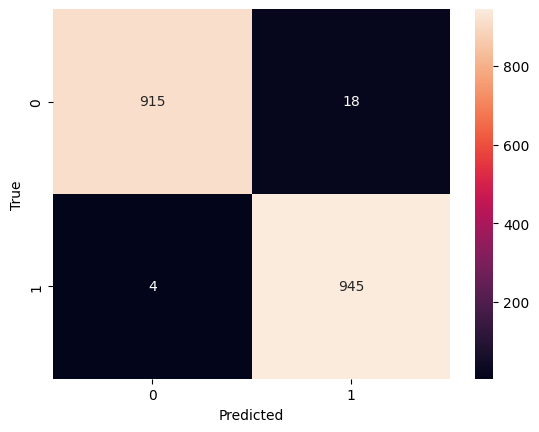

In [15]:
# confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

